# Obtaining subsets of cloud-hosted FITS files using AstroPy

*Prepared by Geert Barentsen, last updated on Nov 8, 2022.*

## Summary

This notebook details and demonstrates a [new feature](https://docs.astropy.org/en/latest/whatsnew/5.2.html#accessing-cloud-hosted-fits-files) in AstroPy v5.2 which enables [subsets of cloud-hosted FITS files](https://docs.astropy.org/en/latest/io/fits/usage/cloud.html) to be obtained efficiently.  For example:

In [1]:
%%time
from astropy.io import fits

# 213 MB FITS file hosted in S3
s3_uri = "s3://stpubdata/hst/public/j8pu/j8pu0y010/j8pu0y010_drc.fits"

with fits.open(s3_uri, fsspec_kwargs={"anon": True}) as hdul:
    print(hdul[1].section[10:12, 30:32])

[[-0.00546263  0.00399334]
 [ 0.00568457 -0.0113019 ]]
CPU times: user 579 ms, sys: 1 s, total: 1.58 s
Wall time: 1.97 s


Bonus: the mechanism is compatible with AstroPy's Cutout2D feature:

In [2]:
%%time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

position = SkyCoord('10h01m41.13s 02d25m20.58s')
size = 5*u.arcsec
 
with fits.open(s3_uri, fsspec_kwargs={"anon": True}) as hdul:
    wcs = WCS(hdul[1].header)
    cutout = Cutout2D(hdul[1].section,
                      position=position,
                      size=size,
                      wcs=wcs)

CPU times: user 469 ms, sys: 90.7 ms, total: 560 ms
Wall time: 3.45 s


This gave us the following galaxy cut-out:

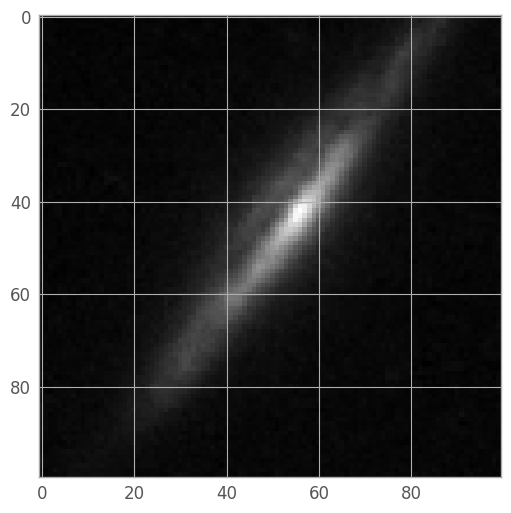

In [3]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)  
plt.figure()  
plt.imshow(cutout.data, cmap='gray');

The remainder of this notebook will demonstrate this new feature in more detail.

# How does it work?

## 1. Example data set

For demonstration purposes, we selected a single 214 MB FITS file containing an HST/ACS image obtained as part of the *COSMOS 2-Degree ACS Survey* near coordinates (ra, dec) = (150.421375, 2.422383).  I selected Hubble data because it is easy to interpret and readily available on S3.  Everything in this notebook should apply to FITS files from any project however.

For simplicity, we will assume that the user has already discovered the data set (e.g. using astroquery) and has obtained the following file URIs:

In [4]:
# HTTP URL of the FITS file at MAST
http_uri = "https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:HST/product/j8pu0y010_drc.fits"

# AWS S3 URI of the same FITS file
s3_bucket = "stpubdata"
s3_key = "hst/public/j8pu/j8pu0y010/j8pu0y010_drc.fits"
s3_uri = f"s3://{s3_bucket}/{s3_key}"

# Location of the data on local disk
local_path = "tmp/j8pu0y010_drc.fits"

## 2. Prior art: downloading the entire file prior to opening

At present, users can already pass HTTP urls to `astropy.io.fits.open(url)`.  AstroPy will recognize the url and download the entire file to the local filesystem before opening the file.

We benchmark that behavior here by downloading the file using the AWS `boto3` library and subsequently opening the file using AstroPy.

In [5]:
%%time
import boto3  # official AWS SDK
from botocore import UNSIGNED
from botocore.config import Config

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3.download_file(s3_bucket, s3_key, local_path)

CPU times: user 1.97 s, sys: 1.25 s, total: 3.22 s
Wall time: 21.9 s


In [6]:
# How much data did we download?
import os
size = os.path.getsize(local_path) / (1024*1024)
print(f"Downloaded {size:.0f} MB")

Downloaded 214 MB


Having downloaded the FITS file, it is trivial to open the file using AstroPy and plot a subset contained in HDU #1:

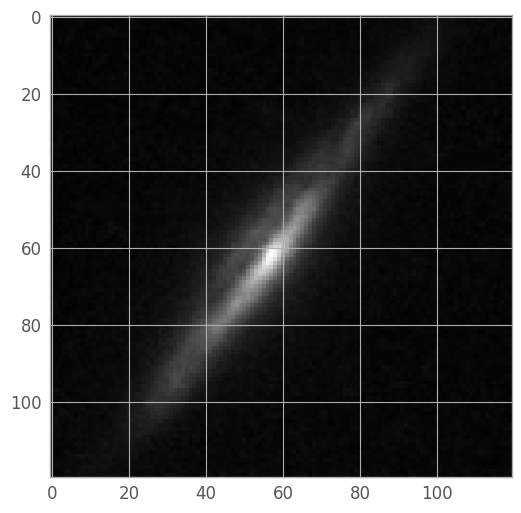

In [7]:
hdulist = fits.open(local_path)
plt.imshow(hdulist[1].data[1700:1820, 2060:2180], cmap='gray');

## 3. How do we avoid downloading the entire file?

Downloading the entire file is inefficient, because we only required a small part of a single HDU. Using `hdulist.info()` we can observe that the FITS file contains three additional large HDU's which we did not require:

In [8]:
hdulist.info()

Filename: tmp/j8pu0y010_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     838   ()      
  1  SCI           1 ImageHDU        81   (4223, 4421)   float32   
  2  WHT           1 ImageHDU        44   (4223, 4421)   float32   
  3  CTX           1 ImageHDU        37   (4223, 4421)   int32   
  4  HDRTAB        1 BinTableHDU    593   8R x 292C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, K, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 4A, L, D, D, D, 3A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 6A, 9A, 8A, D, D, L, 4A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 1A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D, 

How much unnecessary data did we download?  Let's have a look at the byte structure of the FITS file:

In [9]:
from fornaxutils import print_byte_layout
print_byte_layout(hdulist)

HDU       hdrLoc      dataLoc  size
           bytes        bytes    MB
  0            0        69120     0
  1        69120        77760    71
  2     74759040     74764800    71
  3    149446080    149451840    71
  4    224133120    224182080     0



The table above shows that HDU #1 is 71 MB in size.  We can improve on the baseline benchmark by a factor ~3 by downloading this 71 MB section rather than the entire 214 MB file.  The table also shows the byte positions of the header (`hdrLoc`) and data section (`dataLoc`) of each HDU for future reference.

## 4. Leveraging AstroPy's existing lazy data loading mechanism

For local files, AstroPy supports reading only the required HDUs via the `lazy_load_hdus` configuration parameter provided by [astropy.io.fits.open](https://docs.astropy.org/en/stable/io/fits/api/files.html#astropy.io.fits.open).  This mode is enabled by default and prevents AstroPy from loading HDU data into memory until it is required by the user.

Specifically:
* The header of a HDU is only read into memory once `HDUList.__getitem__()` is called for that HDU.
* The data of a HDU is only read once the `.data` property of an HDU object is accessed (i.e., `.data` is implemented using the `@lazyproperty` decorator).

For example:

In [10]:
# This line loads the primary header into memory
with fits.open(local_path, lazy_load_hdus=True) as hdulist:
    
    # This line loads the header of HDU #2 into memory
    hdu2 = hdulist[2]
    
    # This line loads the data of HDU #2 into memory
    data2 = hdulist[2].data

AstroPy implements this feature using the ability of the Python file object to read sub-sections of data using standard OS random file access operations.  For example, we can read a single header keyword from a local file as follows:

In [11]:
f = open(local_path)
f.seek(560) # move to byte position 560
f.read(80)  # read 80 bytes

"TELESCOP= 'HST'                / telescope used to acquire data                 "

Historically such random access file operations could only be used on local files.  In recent years, identical file object APIs have been created to enable seamless random access to remote file systems (including AWS S3, Google Cloud Storage, Azure Blob Storage, etc). These APIs have been grouped in the [fsspec project](https://filesystem-spec.readthedocs.io/en/latest/) which has its roots within the [Dask project](https://dask.org/) and is e.g. a core dependency of `pandas`.

For example, we can efficiently read the same bytes from the FITS file using [s3fs](https://s3fs.readthedocs.io/en/latest/), which is the fsspec-based package to access data from AWS s3:

In [12]:
from s3fs import S3FileSystem

s3fs = S3FileSystem(anon=True)
with s3fs.open(s3_uri, mode="rb") as fh:
    fh.seek(560)
    print(fh.read(79))

b"TELESCOP= 'HST'                / telescope used to acquire data                "


Behind the scenes, `s3fs` uses the AWS SDK to fetch data using byte-range GET requests.  To observe the exact behavior, I created a custom [`FsspecMonitor`](https://github.com/barentsen/fsspec-monitor) tool which monkey-patches fsspec to reveal the data transfer behavior (shown as red text):

In [13]:
# https://github.com/barentsen/fsspec-monitor
from fsspecmonitor import FsspecMonitor

with FsspecMonitor() as monitor:
    with s3fs.open(s3_uri, mode="rb", block_size=80, cache_type="block") as fh:
        fh.seek(560)
        fh.read(79)
    monitor.summary()

Reading stpubdata/hst/public/j8pu/j8pu0y010/j8pu0y010_drc.fits (213.82 MB)
Fetch bytes 560-640 (0.00 MB/s)
Summary: fetched 80 bytes (0.00 MB) in 0.10 s (0.00 MB/s) using 1 requests.


Note: the `block_size` and `cache_type` parameters passed to fsspec's `open()` function play an important role in determining the performance.  These parameters control the size and frequency of the underlying GET requests that will be made to the remote server, similar to the way in which an operating system's *page size* impacts the efficency of swapping data between disk and memory.  The ideal values of these settings will depend on the use case, the network latency, and the server throughput.

We can access files exposed by the MAST HTTP server in the same way by substituting `S3FileSystem` with `HTTPFileSystem`. For example:

In [14]:
from fsspec.implementations.http import HTTPFileSystem

with FsspecMonitor() as monitor:
    httpfs = HTTPFileSystem()
    with httpfs.open(http_uri, mode='rb', block_size=80, cache_type="block") as fh:
        fh.seek(560)
        fh.read(79)
    monitor.summary()

Reading https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:HST/product/j8pu0y010_drc.fits (213.82 MB)
Fetch bytes 560-640 (0.00 MB/s)
Summary: fetched 80 bytes (0.00 MB) in 0.11 s (0.00 MB/s) using 1 requests.


Other available options offered by fsspec include `GCSFileSystem` (Google Cloud), `AzureBlobFileSystem`, `HadoopFileSystem`, `FTPFileSystem`, `LocalFileSystem`, and many more.

## 5. Integration of `fsspec` into Astropy v5.2

AstroPy v5.2 adds `fsspec` as an optional dependency, i.e., it is automatically installed using:

    pip install astropy[all]

We modified the [get_readable_filobj](https://docs.astropy.org/en/latest/api/astropy.utils.data.get_readable_fileobj.html?highlight=get_readable_fileobj) helper function in `astropy.utils.data` to support returning an `fsspec`-based file handle. For example:

In [15]:
from astropy.utils.data import get_readable_fileobj

with get_readable_fileobj(s3_uri,
                          use_fsspec=True,
                          fsspec_kwargs={'anon': True, 'default_block_size': 80}) as fh:
    fh.seek(560)
    print(fh.read(79))

TELESCOP= 'HST'                / telescope used to acquire data                


Success! We can now trick AstroPy into thinking that an S3-hosted file is stored locally and supports random access. For example, we can read the header of HDU #4 by transferring only a tiny fraction of the FITS file:

In [16]:
with FsspecMonitor() as monitor:
    with fits.open(s3_uri, fsspec_kwargs={'anon': True, 'default_block_size': 100_000}) as hdul:
        hdr = hdul[2].header
    monitor.summary()

Reading stpubdata/hst/public/j8pu/j8pu0y010/j8pu0y010_drc.fits (213.82 MB)
Fetch bytes 0-100004 (0.36 MB/s)
Fetch bytes 74759040-74861920 (0.56 MB/s)
Summary: fetched 202884 bytes (0.19 MB) in 0.44 s (0.44 MB/s) using 2 requests.


Next, let's try accessing data by plotting the same cutout from HDU 1 as we did before:

Reading stpubdata/hst/public/j8pu/j8pu0y010/j8pu0y010_drc.fits (213.82 MB)
Fetch bytes 0-5242884 (13.11 MB/s)
Fetch bytes 77760-80000172 (6.72 MB/s)
Summary: fetched 85165296 bytes (81.22 MB) in 11.72 s (6.93 MB/s) using 2 requests.


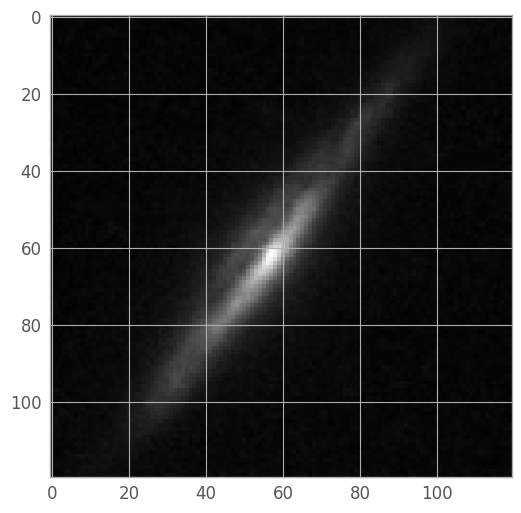

In [17]:
with FsspecMonitor() as monitor:
    with fits.open(s3_uri, fsspec_kwargs={'anon': True}) as hdul:
        plt.imshow(hdul[1].data[1700:1820, 2060:2180], cmap='gray');
    monitor.summary()

As expected, AstroPy is able to access the image stored in HDU #1 without requiring the other image extensions to be loaded (i.e., only ~71 MB was downloaded rather than 214 MB).  Unfortunately, AstroPy does load the entire data section of HDU #1 rather than downloading only the cutout.

# 6. How to avoid loading an entire HDU?

We would like to limit the data transfer to the bytes needed to plot the cutout region, rather than downloading the entire image array for HDU #1 (71 MB), 

AstroPy supports reading slices of data via the [memory mapping mechanism](https://docs.astropy.org/en/stable/io/fits/index.html#working-with-large-files) and the [buffer protocol](https://docs.python.org/3/c-api/buffer.html). Specifically, as part of `astropy.io.fits.file._File.readarray()`, AstroPy initializes data arrays by passing a `mmap` object to the `buffer` parameter of `np.ndarray` as follows: 
```python
return np.ndarray(shape=shape, dtype=dtype, offset=offset, buffer=self._mmap)
```

By creating an array in this way, numpy slicing will be translated into file seek/read calls at runtime as needed.  Unfortunately this happens deep inside the Numpy C code (or perhaps even the OS kernel), which makes it difficult to plug the pure-Python file interfaces provided by fsspec into this mechanism.  The buffer protocol is a Python C API concept which cannot be implemented in pure Python. As a result, it seems unlikely that we can repurpose the buffer interface mechanism here.

Instead, we can leverage the existing [ImageHDU.section](https://docs.astropy.org/en/latest/io/fits/api/images.html#astropy.io.fits.ImageHDU.section) property which enables a subset of a data array to be read into memory without downloading the entire image or cube.

Reading stpubdata/hst/public/j8pu/j8pu0y010/j8pu0y010_drc.fits (213.82 MB)
Fetch bytes 0-5242884 (3.02 MB/s)
Fetch bytes 28802400-34045760 (3.29 MB/s)
Summary: fetched 10486244 bytes (10.00 MB) in 3.18 s (3.15 MB/s) using 2 requests.


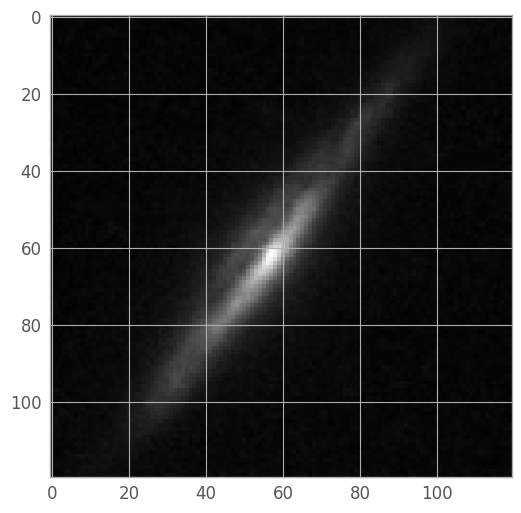

In [18]:
with FsspecMonitor() as monitor:
    with fits.open(s3_uri, fsspec_kwargs={'anon': True}) as hdul:
        plt.imshow(hdul[1].section[1700:1820, 2060:2180], cmap='gray');
    monitor.summary()

The `.section` property can also be passed to `Cutout2D`:

In [20]:
with FsspecMonitor() as monitor:

    with fits.open(s3_uri, fsspec_kwargs={"anon": True}) as hdul:
        wcs = WCS(hdul[1].header)
        cutout = Cutout2D(hdul[1].section,
                          position=position,
                          size=size,
                          wcs=wcs)
    monitor.summary()

Reading stpubdata/hst/public/j8pu/j8pu0y010/j8pu0y010_drc.fits (213.82 MB)
Fetch bytes 0-5242884 (4.83 MB/s)
Fetch bytes 28177172-33420908 (8.23 MB/s)
Summary: fetched 10486620 bytes (10.00 MB) in 1.64 s (6.09 MB/s) using 2 requests.


## References

* Astropy docs chapter: [Obtaining subsets from cloud-hosted FITS files](https://docs.astropy.org/en/latest/io/fits/usage/cloud.html)
* Astropy docs: [astropy.io.fits.open](https://docs.astropy.org/en/latest/io/fits/api/files.html#astropy.io.fits.open)
* [GitHub Pull Request](https://github.com/astropy/astropy/pull/13238)


## Footnotes

* HDF5 v1.10.6 and later supports cloud-hosted files in a similar way by providing the [S3 Virtual File Driver](https://portal.hdfgroup.org/display/HDF5/H5P_SET_FAPL_ROS3) (a role fulfilled by `s3fs` in our case).